## **Installation of Required Packages**

In [1]:
# !pip install "tweet-preprocessor==0.5.0"
# !pip install "seaborn==0.9.0"
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')
# nltk.download('averaged_perceptron_tagger')
# # nltk.download('all')

# **Importing Libraries**

In [2]:
# Import packages for fundamental computations
import numpy as np
import pandas as pd
import preprocessor as p
import collections
import os
import re
import string
import time
from scipy.stats import norm
import warnings
from collections import Counter
from string import punctuation

# Import packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from PIL import Image

# Import NLTK packages for text processing
from nltk import FreqDist
from nltk.collocations import *
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize import TweetTokenizer

# Import ML and DL modules for predictive modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Embedding, Conv1D, Flatten, MaxPooling1D
from keras.layers import Activation, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings("ignore", category=DeprecationWarning)

plt.style.use('fivethirtyeight')
%matplotlib inline
%config IPCompleter.greedy=True

In [3]:
# Initialize the GPU support for DL Modeling
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

# **1. Load Dataset**

In [4]:
# Read Covid-19 dataset
original_df = pd.read_csv('TweetsDB.csv')

print("The shape of the dataset is -", original_df.shape)
original_df.head()

The shape of the dataset is - (489269, 11)


,id,created_at,source,original_text,lang,favorite_count,retweet_count,original_author,hashtags,user_mentions,place
0,1386694264550270000,Mon Apr 26 14:50:50 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",RT @VP: The U.S. is working closely with the I...,en,0.0,0.0,jfd4humanrights,NaN,VP,Alabama
1,1386694260213170000,Mon Apr 26 14:50:49 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",RT @JackPosobiec: Flip-Flop Fauci admits outdo...,en,0.0,0.0,andgrateful,NaN,JackPosobiec,NaN
2,1386694256413320000,Mon Apr 26 14:50:48 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...","RT @timmy315: Hi Twitter, I’m Tim Manning, the...",en,0.0,252.0,jlreader8B,NaN,timmy315,NaN
3,1386694252017630000,Mon Apr 26 14:50:47 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @itsaadee: Praying for #India as the countr...,en,0.0,2.0,ijennychauhan,"India, Covid",itsaadee,NaN
4,1386694248284700000,Mon Apr 26 14:50:46 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Rapid Investment in Nursing to Strengthen the ...,en,0.0,7937.0,IJNSJournal,NaN,NaN,UK


# **2. Data Pre-processing**

## **2.1 Initial Cleaning & Pre-processing**

In [5]:
# Dropping all duplicte values
original_df.drop_duplicates(subset ="original_text", keep = "first", inplace = True)

# Changing the date format
original_df['created_at'] = pd.to_datetime(original_df['created_at'], format='%a %b %d %H:%M:%S %z %Y').dt.strftime('%Y-%m-%d')

original_df.to_csv("Final TweetsDB.csv", index=False)

original_df = pd.read_csv('Final TweetsDB.csv')
new_full_df = original_df.copy()

print("The shape of the dataset after removing duplicate tweets -", new_full_df.shape)
new_full_df.head()

The shape of the dataset after removing duplicate tweets - (147475, 11)


,id,created_at,source,original_text,lang,favorite_count,retweet_count,original_author,hashtags,user_mentions,place
0,1386694264550270000,2021-04-26,"<a href=""http://twitter.com/download/android"" ...",RT @VP: The U.S. is working closely with the I...,en,0.0,0.0,jfd4humanrights,NaN,VP,Alabama
1,1386694260213170000,2021-04-26,"<a href=""http://twitter.com/download/iphone"" r...",RT @JackPosobiec: Flip-Flop Fauci admits outdo...,en,0.0,0.0,andgrateful,NaN,JackPosobiec,NaN
2,1386694256413320000,2021-04-26,"<a href=""http://twitter.com/download/iphone"" r...","RT @timmy315: Hi Twitter, I’m Tim Manning, the...",en,0.0,252.0,jlreader8B,NaN,timmy315,NaN
3,1386694252017630000,2021-04-26,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @itsaadee: Praying for #India as the countr...,en,0.0,2.0,ijennychauhan,"India, Covid",itsaadee,NaN
4,1386694248284700000,2021-04-26,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Rapid Investment in Nursing to Strengthen the ...,en,0.0,7937.0,IJNSJournal,NaN,NaN,UK


## **2.2 Data Exploration**

In [6]:
# Finding frequency of tweets
freq_tweet_df = pd.DataFrame()
freq_tweet_df["Date"] = new_full_df['created_at']
freq_tweet_df["Tweets_Freq"] = new_full_df['original_text']
freq_tweet_df = freq_tweet_df.groupby('Date')['Tweets_Freq'].count().reset_index()
freq_tweet_df.head()

,Date,Tweets_Freq
0,2021-04-26,3318
1,2021-04-27,220
2,2021-04-28,3365
3,2021-04-29,593
4,2021-04-30,1540


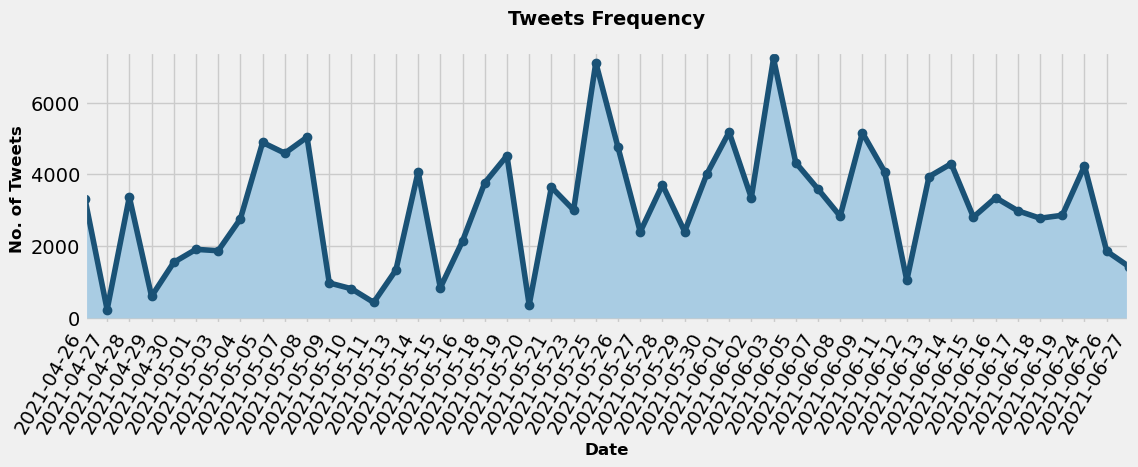

In [7]:
# Visualize the frequency of tweets
fig, ax = plt.subplots(figsize=(12, 4))
plt.title('Tweets Frequency', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('No. of Tweets', fontsize=12, fontweight='bold')

Frequency = freq_tweet_df['Tweets_Freq']
Date = freq_tweet_df['Date']
plt.plot(Date, Frequency,'o-', color="#1a5276")
plt.fill_between(Date, Frequency, color="#a9cce3")
plt.margins(0.0, 0.025)
fig.autofmt_xdate()

for tick in ax.get_xticklabels():
    tick.set_rotation(60)
plt.show()

## **2.3 Text Pre-processing**

In [8]:
# Remove urls, RT, handles, and the hashtag from hashtags
def remove_urls(text):
    new_text = re.sub(r'amp;', '', str(text))
    new_text = re.sub(r':', '', str(new_text))
    new_text = re.sub(r'‚Ä¶', '', str(new_text))
    #replace consecutive non-ASCII characters with a space
    new_text = re.sub(r'[^\x00-\x7F]+',' ', str(new_text))
    new_text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",str(new_text)).split())
    return new_text

# Make all text lowercase
def text_lowercase(text):
    return text.lower()

# Remove numbers
def remove_numbers(text):
    result = re.sub(r'\d+', '', str(text))
    return result

# Remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

# Tokenize
def tokenize(text):
    text = word_tokenize(text)
    return text

# Remove stopwords
stop_words = stopwords.words("english")
stop_words.extend(['nan', 'amp', 'th', 'u'])
def remove_stopwords(text):
    text = [i for i in text if not i in stop_words]
    return text

# Lemmatize
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    text = [lemmatizer.lemmatize(token) for token in text]
    return text

# Remove single characters
def remove_singleword(text):
    text = [word for word in text if len(word) > 1]
    return text

# Pre-processing function
def preprocessing(text):
    text = remove_urls(text)
    text = text_lowercase(text)
    text = remove_numbers(text)
    text = remove_punctuation(text)
    text = tokenize(text)
    text = remove_stopwords(text)
    text = lemmatize(text)
    text = remove_singleword(text)
    text = ' '.join(text)
    text = re.sub(r'covid', '', str(text))
    return text

In [9]:
clean_text = []    #preprocessed text column
for text_data in new_full_df['original_text']:
    pp_text_data = p.clean(str(text_data))
    clean_text_data = preprocessing(pp_text_data)
    clean_text.append(clean_text_data)

# Add the preprocessed text as a column
new_full_df['clean_tweet'] = clean_text
new_full_df.head()

,id,created_at,source,original_text,lang,favorite_count,retweet_count,original_author,hashtags,user_mentions,place,clean_tweet
0,1386694264550270000,2021-04-26,"<a href=""http://twitter.com/download/android"" ...",RT @VP: The U.S. is working closely with the I...,en,0.0,0.0,jfd4humanrights,NaN,VP,Alabama,working closely indian government rapidly depl...
1,1386694260213170000,2021-04-26,"<a href=""http://twitter.com/download/iphone"" r...",RT @JackPosobiec: Flip-Flop Fauci admits outdo...,en,0.0,0.0,andgrateful,NaN,JackPosobiec,NaN,flip flop fauci admits outdoor transmission low
2,1386694256413320000,2021-04-26,"<a href=""http://twitter.com/download/iphone"" r...","RT @timmy315: Hi Twitter, I’m Tim Manning, the...",en,0.0,252.0,jlreader8B,NaN,timmy315,NaN,hi twitter tim manning white house supply coo...
3,1386694252017630000,2021-04-26,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @itsaadee: Praying for #India as the countr...,en,0.0,2.0,ijennychauhan,"India, Covid",itsaadee,NaN,praying country battle worst surge world witne...
4,1386694248284700000,2021-04-26,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Rapid Investment in Nursing to Strengthen the ...,en,0.0,7937.0,IJNSJournal,NaN,NaN,UK,rapid investment nursing strengthen global re...


In [10]:
# Save the preprocessed tweets into "Final TweetsDB" dataframe
df = pd.read_csv('Final TweetsDB.csv')
df["clean_tweet"] = new_full_df['clean_tweet']

df.to_csv("Final TweetsDB.csv", index=False)

# **3. Feature A: Covid-19 Specified Words Identification**

## **3.1 Visualization of Covid-19 Specified Words**

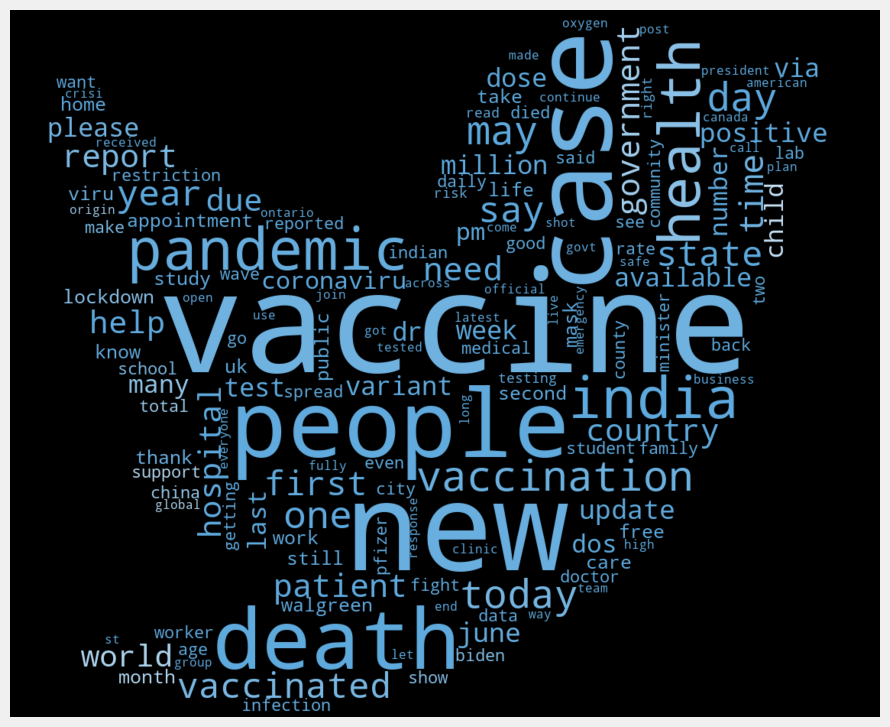

In [11]:
# Visualize of all popular words using wordcloud (Twitter Logo Mapping)
new_full_df = pd.read_csv('Final TweetsDB.csv')
all_words = ' '.join(str(text) for text in new_full_df['clean_tweet'])

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
Mask = np.array(Image.open(os.path.join(d, "twitter_mask.png")))

image_colors = ImageColorGenerator(Mask)

wc = WordCloud(background_color='black', height=1500, width=4000, max_words=150, stopwords=STOPWORDS, collocations=False, mask=Mask).generate(all_words)

plt.figure(figsize=(10,20))

plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")

plt.axis('off')
plt.show()

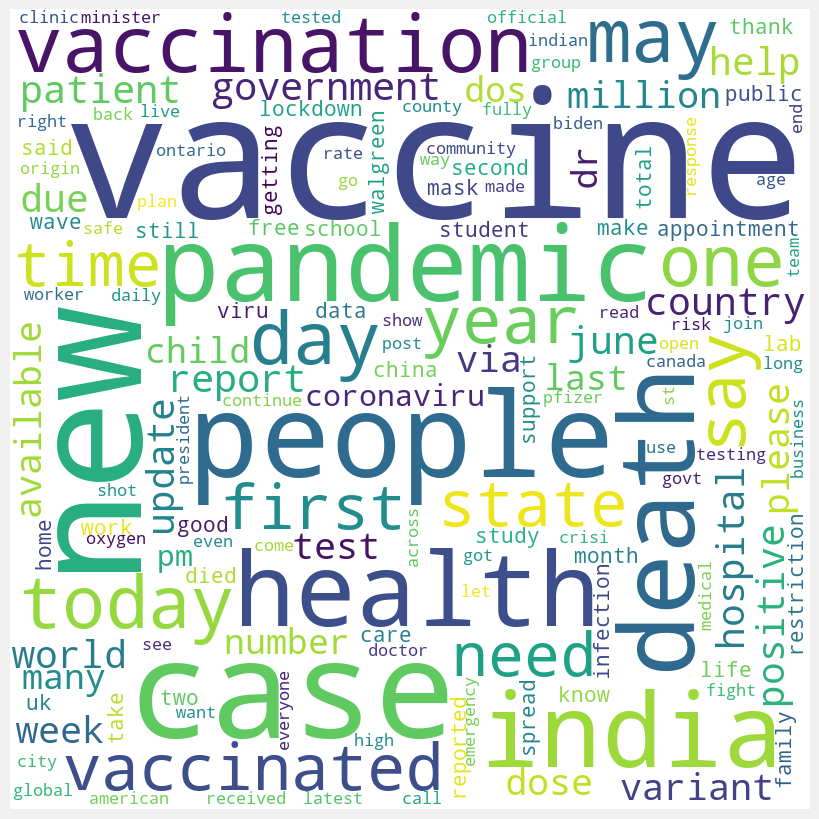

In [12]:
# Visualize of all popular words using wordcloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color = 'white',
                min_font_size = 15,
                max_words = 150,
                stopwords = STOPWORDS,
                collocations = False).generate(all_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## **3.2 Part-of-Speech Tagging**

In [13]:
tweet_text = new_full_df.clean_tweet.tolist()
custom_sent_tokenizer = PunktSentenceTokenizer(tweet_text)

tokenized = custom_sent_tokenizer.tokenize(all_words)

def process_content():
    try:
        for i in tokenized:
            words = nltk.word_tokenize(i)
            tagged = nltk.pos_tag(words)
            print(tagged, file=open("POS Tagged.txt", "w"))
            print(tagged[0:100])
    except Exception as e:
        print(str(e))

process_content()

[('working', 'VBG'), ('closely', 'RB'), ('indian', 'JJ'), ('government', 'NN'), ('rapidly', 'RB'), ('deploy', 'VBD'), ('additional', 'JJ'), ('support', 'NN'), ('supply', 'NN'), ('alarming', 'VBG'), ('flip', 'NN'), ('flop', 'NN'), ('fauci', 'NN'), ('admits', 'VBZ'), ('outdoor', 'JJ'), ('transmission', 'NN'), ('low', 'JJ'), ('hi', 'NN'), ('twitter', 'NN'), ('tim', 'NN'), ('manning', 'VBG'), ('white', 'JJ'), ('house', 'NN'), ('supply', 'NN'), ('coordinator', 'NN'), ('lot', 'NN'), ('confusion', 'NN'), ('around', 'IN'), ('use', 'IN'), ('praying', 'VBG'), ('country', 'NN'), ('battle', 'NN'), ('worst', 'JJS'), ('surge', 'NN'), ('world', 'NN'), ('witnessed', 'VBD'), ('let', 'RBR'), ('irrespective', 'JJ'), ('rapid', 'JJ'), ('investment', 'NN'), ('nursing', 'NN'), ('strengthen', 'NN'), ('global', 'JJ'), ('response', 'NN'), ('today', 'NN'), ('viza', 'VBP'), ('pleased', 'VBN'), ('learn', 'JJ'), ('ceo', 'NN'), ('spouse', 'NN'), ('anu', 'JJ'), ('nadella', 'RB'), ('donated', 'JJ'), ('amount', 'NN'), 

### **3.2.1 Word Filtering**

In [14]:
# split into words
tokens = word_tokenize(all_words)
word_dist = nltk.FreqDist(tokens)

# convert to lower case
tokens = [w.lower() for w in tokens]

# remove punctuation from each word
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in tokens]

print(tokens[0:], file=open("Covid Tokens.txt", "w"))
print(tokens[0:100])

['working', 'closely', 'indian', 'government', 'rapidly', 'deploy', 'additional', 'support', 'supply', 'alarming', 'flip', 'flop', 'fauci', 'admits', 'outdoor', 'transmission', 'low', 'hi', 'twitter', 'tim', 'manning', 'white', 'house', 'supply', 'coordinator', 'lot', 'confusion', 'around', 'use', 'praying', 'country', 'battle', 'worst', 'surge', 'world', 'witnessed', 'let', 'irrespective', 'rapid', 'investment', 'nursing', 'strengthen', 'global', 'response', 'today', 'viza', 'pleased', 'learn', 'ceo', 'spouse', 'anu', 'nadella', 'donated', 'amount', 'crore', 'legal', 'action', 'launched', 'italian', 'woman', 'dy', 'week', 'hav', 'via', 'ft', 'rule', 'stop', 'spread', 'indoors', 'mit', 'study', 'please', 'aware', 'ecdoh', 'scheduled', 'three', 'vaccination', 'clinic', 'especially', 'year', 'old', 'useful', 'twitter', 'handle', 'watch', 'video', 'reduce', 'impact', 'india', 'dr', 'priya', 'sampathkumar', 'md', 'chair', 'official', 'statement', 'apgujeong', 'high', 'school', 'urgent']


## **3.3 Covid-19 Specified Words Popularity**

In [15]:
# Calculate word popularity
word_counts = collections.Counter(tokens)
word_counts.most_common()

word_counts_df = pd.DataFrame(word_counts.most_common(),
                             columns=['Word', 'Popularity'])
word_counts_df.head()

,Word,Popularity
0,vaccine,19776
1,new,12009
2,case,11607
3,people,8414
4,death,6365


In [16]:
# Calculate probability of word popularity
probability = []
total_words_count = word_counts_df['Popularity'].sum()

for i in range(0,len(word_counts_df.index)):
    word_probability = word_counts_df['Popularity'].iloc[i] / total_words_count
    probability.append(word_probability)

word_counts_df['Probability'] = probability
word_counts_df = word_counts_df.dropna()
word_counts_df.to_csv("Word Frequency.csv", index=False)
word_counts_df.head()

,Word,Popularity,Probability
0,vaccine,19776,0.014953
1,new,12009,0.009080
2,case,11607,0.008776
3,people,8414,0.006362
4,death,6365,0.004813


### **3.3.1 Word Filtering**

In [17]:
# Filter words based on probability of word popularity
word = []
popularity = []
probability = []

specific_word_df = pd.DataFrame()
specific_word_df["Word"] = ""
specific_word_df["Popularity"] = ""
specific_word_df["Probability"] = ""

for i in range(0,len(word_counts_df.index)):
    if word_counts_df['Probability'].iloc[i] >= 0.000001:
        word.append(word_counts_df['Word'].iloc[i])
        popularity.append(word_counts_df['Popularity'].iloc[i])
        probability.append(word_counts_df['Probability'].iloc[i])

specific_word_df['Word'] = word
specific_word_df['Popularity'] = popularity
specific_word_df['Probability'] = probability
specific_word_df = specific_word_df.dropna()
specific_word_df.to_csv("Covid-19 Specific Words.csv", index=False)
specific_word_df.head()

,Word,Popularity,Probability
0,vaccine,19776,0.014953
1,new,12009,0.009080
2,case,11607,0.008776
3,people,8414,0.006362
4,death,6365,0.004813


### **3.3.2 Visualization of Word Popularity**

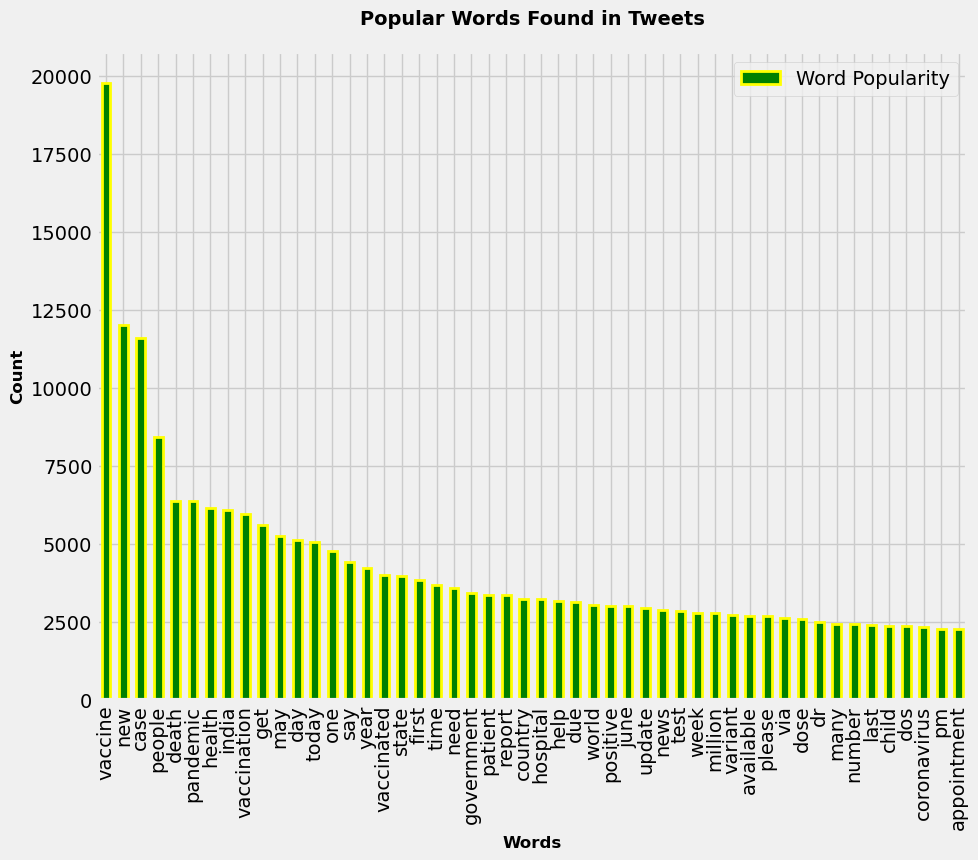

In [18]:
# Visualize word popularity
top_specific_word_df = specific_word_df.head(50)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot horizontal bar graph
top_specific_word_df.sort_values(ascending=False,
                           kind='quicksort',
                           by='Popularity').plot.bar(x='Word',
                                                y='Popularity',
                                                ax=ax,
                                                edgecolor="yellow",
                                                linewidth=2,
                                                color="green")

ax.set_title("Popular Words Found in Tweets", fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel("Words", fontsize=12, fontweight='bold')
ax.set_ylabel("Count", fontsize=12, fontweight='bold')
ax.legend(["Word Popularity"], loc ="upper right")
plt.show()

# **4. Feature B: Word Popularity Detection using N-gram**

## **4.1 Unigram Analysis**

In [19]:
ug_count = Counter(tokens).most_common()
print(ug_count, file=open("Unigram Analysis.txt", "w"))
print(ug_count[0:100])

[('vaccine', 19776), ('new', 12009), ('case', 11607), ('people', 8414), ('death', 6365), ('pandemic', 6359), ('health', 6139), ('india', 6096), ('vaccination', 5952), ('get', 5615), ('may', 5242), ('day', 5137), ('today', 5063), ('one', 4775), ('say', 4402), ('year', 4219), ('vaccinated', 4016), ('state', 3953), ('first', 3851), ('time', 3677), ('need', 3571), ('government', 3434), ('patient', 3372), ('report', 3359), ('country', 3245), ('hospital', 3242), ('help', 3178), ('due', 3119), ('world', 3042), ('positive', 3014), ('june', 3009), ('update', 2957), ('news', 2869), ('test', 2845), ('week', 2770), ('million', 2768), ('variant', 2723), ('available', 2680), ('please', 2672), ('via', 2621), ('dose', 2597), ('dr', 2502), ('many', 2446), ('number', 2440), ('last', 2414), ('child', 2374), ('dos', 2363), ('coronavirus', 2341), ('pm', 2280), ('appointment', 2277), ('know', 2277), ('like', 2243), ('second', 2214), ('virus', 2160), ('still', 2157), ('take', 2122), ('mask', 2073), ('care', 

### **4.1.1 Visualization of Unigrams**

C:\Users\Arunava\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

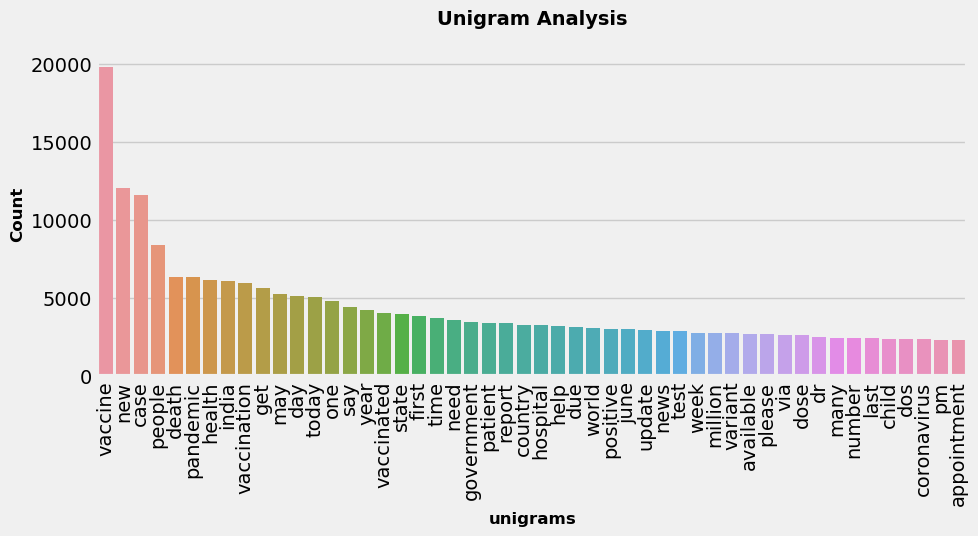

In [20]:
ug_count = Counter(tokens).most_common(50)
ug_dict = dict(ug_count)
ug_dict_sorted = sorted(ug_dict.items(), key=lambda kv: kv[1], reverse=True)
ug, uni_counts = list(zip(*ug_dict_sorted))
ug_str = list(ug)
uni_counts = list(map(int, uni_counts))
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(ug_str, uni_counts)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_title("Unigram Analysis", fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel("unigrams", fontsize=12, fontweight='bold')
ax.set_ylabel("Count", fontsize=12, fontweight='bold')

## **4.2 Bigram Analysis**

In [21]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tokens)
finder.apply_freq_filter(3)
print(finder.nbest(bigram_measures.pmi, 100))

[('advetise', 'busienss'), ('alyssa', 'milano'), ('azim', 'premji'), ('bhima', 'koregaon'), ('bhupesh', 'baghel'), ('botanical', 'conservatory'), ('cecilia', 'chimbiri'), ('chanda', 'qila'), ('colonially', 'patronising'), ('dwelling', 'slanderous'), ('eign', 'emporarily'), ('etting', 'njoyment'), ('extripod', 'quotation'), ('famcro', 'samily'), ('feazelle', 'muddyum'), ('fnw', 'laloche'), ('galicia', 'incidencia'), ('gregg', 'jarrett'), ('greta', 'thunberg'), ('guillermo', 'eleazar'), ('gynecology', 'obstetric'), ('himanshi', 'khurana'), ('incidencia', 'acumulada'), ('katrina', 'kaif'), ('keyword', 'khojinindia'), ('laloche', 'beauval'), ('lleviate', 'pathy'), ('lujan', 'grisham'), ('marquino', 'mindley'), ('mayra', 'ramirez'), ('netsai', 'marova'), ('nikola', 'mektic'), ('njoyment', 'eign'), ('occam', 'razor'), ('pathy', 'etting'), ('pavic', 'nikola'), ('pernod', 'ricard'), ('pineal', 'gland'), ('povidone', 'iodine'), ('rahima', 'moosa'), ('ramanan', 'laxminarayan'), ('salma', 'hayek'

In [22]:
bgs = nltk.bigrams(tokens)

#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(bgs)
bg_count = Counter(fdist).most_common()
print(bg_count, file=open("Bigram Analysis.txt", "w"))
print(bg_count[0:100])

[(('new', 'case'), 3478), (('fully', 'vaccinated'), 1013), (('case', 'death'), 912), (('public', 'health'), 848), (('vaccine', 'appointment'), 828), (('year', 'old'), 804), (('appointment', 'available'), 794), (('get', 'vaccine'), 791), (('tested', 'positive'), 782), (('get', 'vaccinated'), 766), (('active', 'case'), 722), (('dose', 'vaccine'), 712), (('second', 'wave'), 676), (('vaccine', 'dos'), 667), (('available', 'walgreens'), 659), (('delta', 'variant'), 658), (('report', 'new'), 616), (('first', 'dose'), 612), (('available', 'appointment'), 585), (('last', 'year'), 579), (('new', 'available'), 578), (('appointment', 'detected'), 578), (('detected', 'provider'), 578), (('zip', 'code'), 567), (('dos', 'vaccine'), 543), (('sign', 'zip'), 516), (('test', 'positive'), 510), (('second', 'dose'), 489), (('wuhan', 'lab'), 488), (('provider', 'walgreens'), 473), (('walgreens', 'location'), 473), (('location', 'walgreens'), 473), (('lab', 'leak'), 466), (('death', 'toll'), 435), (('prime'

### **4.2.1 Visualization of Bigrams**

C:\Users\Arunava\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

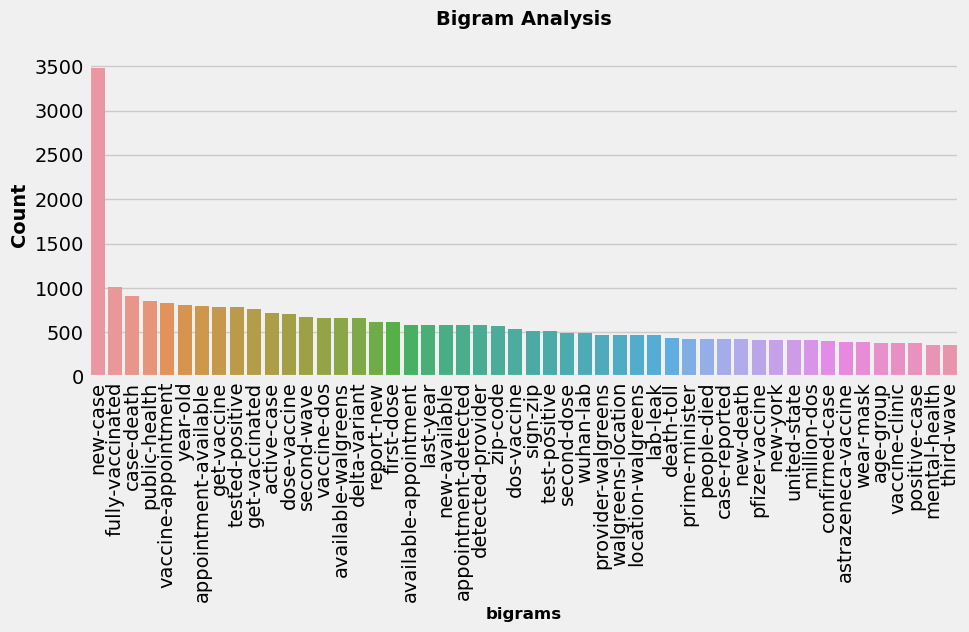

In [23]:
bg_count = Counter(fdist).most_common(50)
bg_dict = dict(bg_count)
bg_dict_sorted = sorted(bg_dict.items(), key=lambda kv: kv[1], reverse=True)
bg, bi_counts = list(zip(*bg_dict_sorted))
bg_str = list(map(lambda x: '-'.join(x), bg))
bi_counts = list(map(int, bi_counts))
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(bg_str, bi_counts)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_title("Bigram Analysis", fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel("bigrams", fontsize=12, fontweight='bold')
ax.set_ylabel("Count", fontsize=14, fontweight='bold')

## **4.3 Trigram Analysis**

In [24]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = TrigramCollocationFinder.from_words(tokens)
finder.apply_freq_filter(3)
print(finder.nbest(trigram_measures.pmi, 100))

[('etting', 'njoyment', 'eign'), ('fnw', 'laloche', 'beauval'), ('galicia', 'incidencia', 'acumulada'), ('lleviate', 'pathy', 'etting'), ('njoyment', 'eign', 'emporarily'), ('pathy', 'etting', 'njoyment'), ('pavic', 'nikola', 'mektic'), ('amptronger', 'transmissability', 'spiralemore'), ('benzolo', 'robala', 'hantle'), ('busuku', 'benzolo', 'robala'), ('kahle', 'busuku', 'benzolo'), ('robala', 'hantle', 'goeie'), ('ulale', 'kahle', 'busuku'), ('sulthan', 'karthi', 'offl'), ('didsbury', 'carstairs', 'innisfail'), ('koutoub', 'moustapha', 'sano'), ('paletta', 'yasmeen', 'abutaleb'), ('swadeshi', 'jagran', 'manch'), ('pacer', 'marquino', 'mindley'), ('centennial', 'botanical', 'conservatory'), ('ministr', 'drazra', 'pechuho'), ('atal', 'bihari', 'vajpayee'), ('sareum', 'tyk', 'sdc'), ('hantle', 'goeie', 'nag'), ('chanda', 'qila', 'bypass'), ('phir', 'sirf', 'hmary'), ('glenn', 'kessler', 'heckled'), ('manky', 'aamir', 'lakhani'), ('ken', 'ofori', 'atta'), ('spotify', 'okta', 'redesigning'

In [25]:
bgs = nltk.trigrams(tokens)

#compute frequency distribution for all the trigrams in the text
fdist = nltk.FreqDist(bgs)
tg_count = Counter(fdist).most_common()
print(tg_count, file=open("Trigram Analysis.txt", "w"))
print(tg_count[0:100])

[(('appointment', 'available', 'walgreens'), 658), (('vaccine', 'appointment', 'available'), 628), (('new', 'available', 'appointment'), 578), (('available', 'appointment', 'detected'), 578), (('appointment', 'detected', 'provider'), 578), (('sign', 'zip', 'code'), 516), (('detected', 'provider', 'walgreens'), 473), (('provider', 'walgreens', 'location'), 473), (('walgreens', 'location', 'walgreens'), 473), (('report', 'new', 'case'), 456), (('new', 'case', 'death'), 344), (('thanks', 'introduced', 'bill'), 321), (('introduced', 'bill', 'seek'), 317), (('bill', 'seek', 'authorize'), 301), (('available', 'walgreens', 'chicago'), 288), (('zip', 'code', 'vaccine'), 277), (('code', 'vaccine', 'appointment'), 275), (('jun', 'sign', 'zip'), 269), (('seek', 'authorize', 'issuance'), 259), (('first', 'dose', 'vaccine'), 252), (('bring', 'fairness', 'thousand'), 248), (('lab', 'leak', 'theory'), 229), (('new', 'availability', 'walgreens'), 227), (('jun', 'jun', 'sign'), 226), (('preparing', 'qu

### **4.3.1 Visualization of Trigrams**

C:\Users\Arunava\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

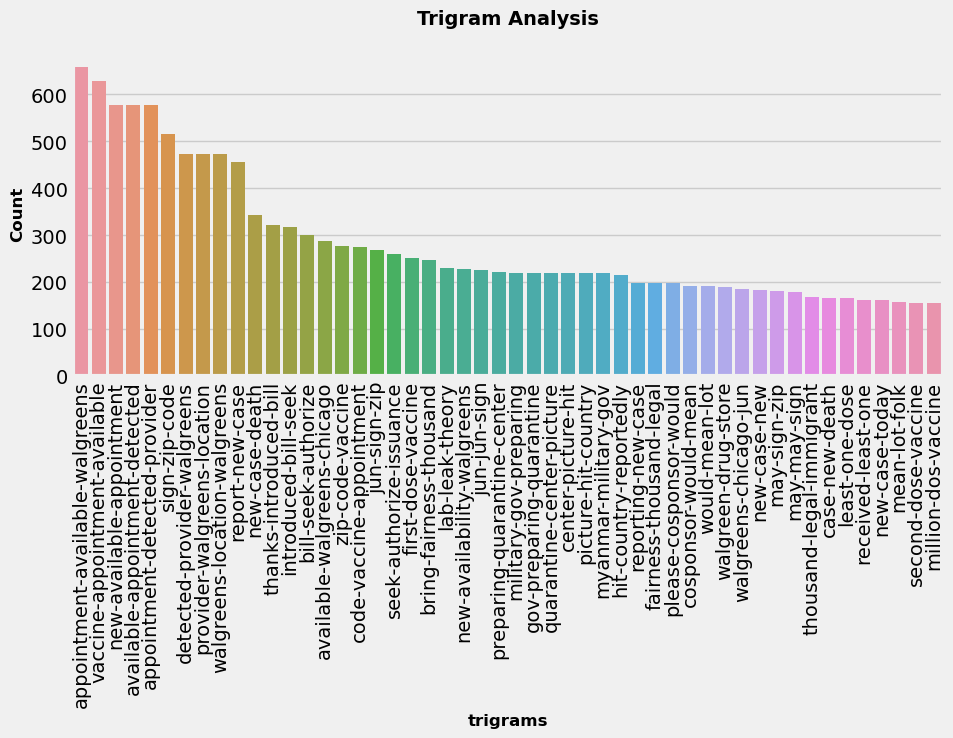

In [26]:
tg_count = Counter(fdist).most_common(50)
tg_dict = dict(tg_count)
tg_dict_sorted = sorted(tg_dict.items(), key=lambda kv: kv[1], reverse=True)
tg, tri_counts = list(zip(*tg_dict_sorted))
tg_str = list(map(lambda x: '-'.join(x), tg))
tri_counts = list(map(int, tri_counts))
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(tg_str, tri_counts)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_title("Trigram Analysis", fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel("trigrams", fontsize=12, fontweight='bold')
ax.set_ylabel("Count", fontsize=12, fontweight='bold')

# **5. Sentiment Analysis on the Clean Tweets**

## **5.1 Sentiment Polarity Calculation**

In [27]:
# Find sentiment polarity for each tweet
def nltk_sentiment(sentence):
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

In [28]:
dataset = new_full_df['clean_tweet'].astype(str)
nltk_results = [nltk_sentiment(row) for row in dataset]
results_df = pd.DataFrame(nltk_results)
text_df = pd.DataFrame(dataset)
sentiment_df = text_df.join(results_df)

## **5.2 Sentimet Classification**

In [29]:
pos_count, neg_count, neu_count, sum_count = 0, 0, 0, 0
per_pos_count, per_neg_count, per_neu_count = 0.0, 0.0, 0.0

for i in range(0,len(sentiment_df.index)):
    if sentiment_df['compound'].iloc[i] < 0:
        neg_count += 1
    elif sentiment_df['compound'].iloc[i] > 0:
        pos_count += 1
    else:
        neu_count += 1

sum_count = neg_count + pos_count + neu_count
per_pos_count = (pos_count/sum_count)*100
per_neu_count = (neu_count/sum_count)*100
per_neg_count = (neg_count/sum_count)*100

print("Percentage of Positive tweets is {:.2f}%".format(per_pos_count))
print("Percentage of Neutral tweets is {:.2f}%".format(per_neu_count))
print("Percentage of Negative tweets is {:.2f}%".format(per_neg_count))

Percentage of Positive tweets is 38.12%
Percentage of Neutral tweets is 32.93%
Percentage of Negative tweets is 28.95%


### **5.2.1 Visualization of Sentimet Classification**

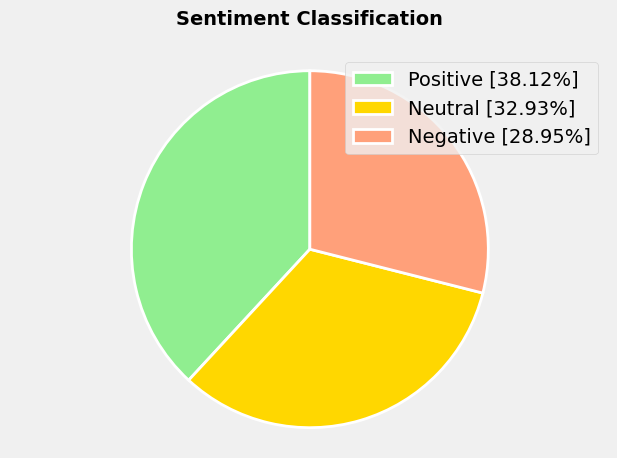

In [30]:
labels = ['Positive [' + str(round(per_pos_count,2)) + '%]',
          'Neutral [' + str(round(per_neu_count,2)) + '%]',
          'Negative [' + str(round(per_neg_count,2)) + '%]']
sizes = [per_pos_count, per_neu_count, per_neg_count]
colors = ['lightgreen', 'gold', 'lightsalmon']
patches, texts = plt.pie(sizes, colors=colors, startangle=90)

for w in patches:
    w.set_linewidth(2)
    w.set_edgecolor('white')

plt.legend(patches, labels, loc="upper right")
plt.title('Sentiment Classification', fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

C:\Users\Arunava\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Arunava\AppData\Local\Temp\ipykernel_13764\973651652.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set(xticklabels=[-1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5])


Text(0, 0.5, 'Frequency')

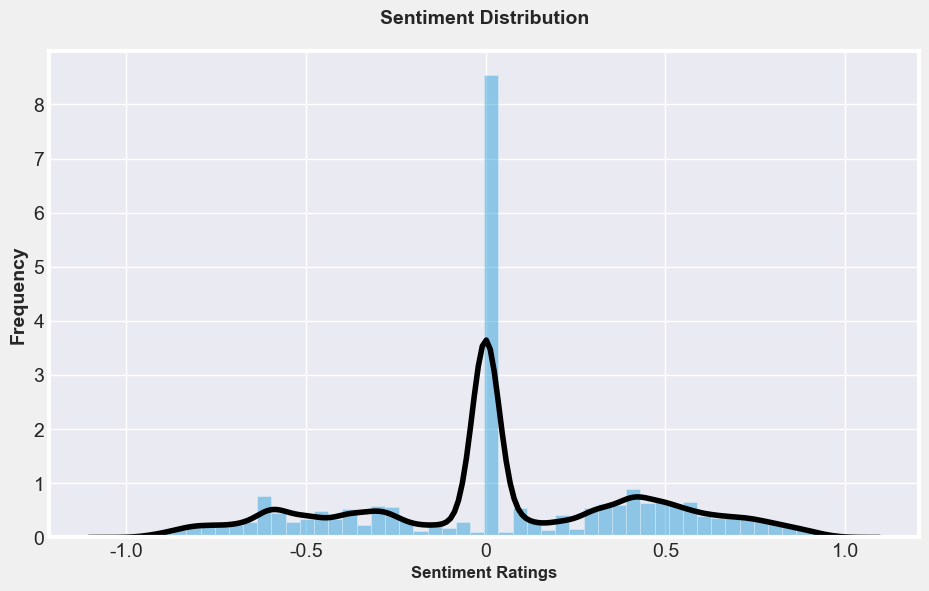

In [31]:
distrubution = sentiment_df['compound']
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
g = sns.distplot(distrubution, kde_kws={"color": "k", "lw": 4, "label": "Distribution"}, kde=True)
g.set(xticklabels=[-1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5])
# plt.xlim(-1.5, 1.5)
plt.title('Sentiment Distribution', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Sentiment Ratings', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# **6. Naïve Bayes Sentiment Modeling**

## **6.1 Data Preparation**

In [32]:
sentiment_df["date"] = original_df['created_at']
sentiment_df.head()

,clean_tweet,neg,neu,pos,compound,date
0,working closely indian government rapidly depl...,0.123,0.656,0.221,0.2960,2021-04-26
1,flip flop fauci admits outdoor transmission low,0.421,0.374,0.206,-0.3182,2021-04-26
2,hi twitter tim manning white house supply coo...,0.167,0.833,0.000,-0.2960,2021-04-26
3,praying country battle worst surge world witne...,0.441,0.395,0.164,-0.6369,2021-04-26
4,rapid investment nursing strengthen global re...,0.000,0.685,0.315,0.3182,2021-04-26


In [33]:
sentiment_df["sentiment"] = ""

for i in range(0,len(sentiment_df.index)):
    if sentiment_df['compound'].iloc[i] < 0:
        sentiment_df['sentiment'].iloc[i] = 'neg'
    elif sentiment_df['compound'].iloc[i] > 0:
        sentiment_df['sentiment'].iloc[i] = 'pos'
    else:
        sentiment_df['sentiment'].iloc[i] = 'neu'

C:\Users\Arunava\AppData\Local\Temp\ipykernel_13764\1994873691.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df['sentiment'].iloc[i] = 'pos'
C:\Users\Arunava\AppData\Local\Temp\ipykernel_13764\1994873691.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df['sentiment'].iloc[i] = 'neg'
C:\Users\Arunava\AppData\Local\Temp\ipykernel_13764\1994873691.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_

In [34]:
new_df = pd.DataFrame()
new_df = pd.read_csv('Final TweetsDB.csv')
new_df[["compound", "neg", "neu", "pos", "sentiment"]] = sentiment_df[['compound', 'neg', 'neu', 'pos', 'sentiment']]
new_df.dropna(subset=['clean_tweet'], inplace=True)
new_df.reset_index(drop=True, inplace=True)
new_df.to_csv("Final TweetsDB.csv", index=False)

In [35]:
cols = ['Date', 'Text', 'Sentiment']
new_sentiment_df = pd.DataFrame(columns=cols, index=range(len(sentiment_df.index)))
for i in range(0,len(sentiment_df.index)):
    if (sentiment_df.iloc[i]['sentiment'] != 'neu'):
        new_sentiment_df.loc[i].Date = sentiment_df.at[i, 'date']
        new_sentiment_df.loc[i].Text = sentiment_df.at[i, 'clean_tweet']
        new_sentiment_df.loc[i].Sentiment = sentiment_df.at[i, 'sentiment']
new_sentiment_df.dropna(inplace=True)
new_sentiment_df.reset_index(drop=True, inplace=True)
data_df = pd.DataFrame()
data_df[['Sentiment', 'Text']] = new_sentiment_df[['Sentiment', 'Text']]
data_df.to_csv("Data.csv", index=False)
data_df.head()

,Sentiment,Text
0,pos,working closely indian government rapidly depl...
1,neg,flip flop fauci admits outdoor transmission low
2,neg,hi twitter tim manning white house supply coo...
3,neg,praying country battle worst surge world witne...
4,pos,rapid investment nursing strengthen global re...


In [36]:
tweet_df = pd.DataFrame()
tweet_df["Text"] = data_df['Text']
tweet_df.to_csv("Tweet Data.csv", index=False)
tweet_df.head()

,Text
0,working closely indian government rapidly depl...
1,flip flop fauci admits outdoor transmission low
2,hi twitter tim manning white house supply coo...
3,praying country battle worst surge world witne...
4,rapid investment nursing strengthen global re...


## **6.2 Naïve Bayes Model Implementation**

In [37]:
tweets = pd.read_csv('Tweet Data.csv', header=0)
data = pd.read_csv('Data.csv', sep=',', names=['Sentiment', 'Text'], dtype=str, header=0)

def split_into_lemmas(tweet):
    ngram_vectorizer = CountVectorizer(ngram_range=(1, 3), token_pattern=r'\b\w+\b', min_df=1)
    analyze = ngram_vectorizer.build_analyzer()
    return analyze(tweet)

bow_transformer = CountVectorizer(analyzer=split_into_lemmas, strip_accents='ascii').fit(data['Text'])

text_bow = bow_transformer.transform(data['Text'])
tfidf_transformer = TfidfTransformer().fit(text_bow)
tfidf = tfidf_transformer.transform(text_bow)

text_tfidf = tfidf_transformer.transform(text_bow)

classifier_nb = MultinomialNB().fit(text_tfidf, data['Sentiment'])

sentiments = pd.DataFrame(columns=['text', 'class', 'prob'])
i = 0
for _, tweet in tweets.iterrows():
    i += 1
    try:
        bow_tweet = bow_transformer.transform(tweet)
        tfidf_tweet = tfidf_transformer.transform(bow_tweet)
        sentiments.loc[i-1, 'text'] = tweet.values[0]
        sentiments.loc[i-1, 'class'] = classifier_nb.predict(tfidf_tweet)[0]
        sentiments.loc[i-1, 'prob'] = classifier_nb.predict_proba(tfidf_tweet)[0][1]
    except Exception as e:
        sentiments.loc[i-1, 'text'] = tweet.values[0]

sentiments.reset_index(drop=True, inplace=True)
sentiments.to_csv('Sentiments.csv', encoding='utf-8')
sentiments.head()

,text,class,prob
0,working closely indian government rapidly depl...,pos,0.719619
1,flip flop fauci admits outdoor transmission low,neg,0.185753
2,hi twitter tim manning white house supply coo...,neg,0.485902
3,praying country battle worst surge world witne...,neg,0.209571
4,rapid investment nursing strengthen global re...,pos,0.834466


# **7. Sentiment Trend Identification**

## **7.1 Data Preparation**

In [38]:
pos_neg_df = new_df[(new_df['sentiment'] == 'pos') |
                    (new_df['sentiment'] == 'neg')]  # Filter positive and negative tweets
pos_neg_df.reset_index(drop=True, inplace=True)

pos_neg_trend_df = pd.DataFrame()
pos_neg_trend_df["Date"] = pos_neg_df['created_at']
pos_neg_trend_df["Original_Tweet"] = pos_neg_df['original_text']
pos_neg_trend_df["Clean_Tweet"] = sentiments['text']
pos_neg_trend_df["Class"] = sentiments['class']
pos_neg_trend_df["Prob"] = sentiments['prob']
pos_neg_trend_df.head()

,Date,Original_Tweet,Clean_Tweet,Class,Prob
0,2021-04-26,RT @VP: The U.S. is working closely with the I...,working closely indian government rapidly depl...,pos,0.719619
1,2021-04-26,RT @JackPosobiec: Flip-Flop Fauci admits outdo...,flip flop fauci admits outdoor transmission low,neg,0.185753
2,2021-04-26,"RT @timmy315: Hi Twitter, I’m Tim Manning, the...",hi twitter tim manning white house supply coo...,neg,0.485902
3,2021-04-26,RT @itsaadee: Praying for #India as the countr...,praying country battle worst surge world witne...,neg,0.209571
4,2021-04-26,Rapid Investment in Nursing to Strengthen the ...,rapid investment nursing strengthen global re...,pos,0.834466


In [39]:
neutral_df = new_df[new_df['sentiment'] == 'neu']  # Filter neutral tweets

neutral_trend_df = pd.DataFrame()
neutral_trend_df["Date"] = neutral_df['created_at']
neutral_trend_df["Original_Tweet"] = neutral_df['original_text']
neutral_trend_df["Clean_Tweet"] = neutral_df['clean_tweet']
neutral_trend_df["Class"] = 'neu'
neutral_trend_df["Prob"] = 1
neutral_trend_df.head()

,Date,Original_Tweet,Clean_Tweet,Class,Prob
5,2021-04-26,RT @GopiKishorRaja2: #Vizag ప్రజలకు ముఖ్య గమని...,today viza,neu,1
11,2021-04-26,RT @nramind: Watch this video | “Here's what y...,watch video reduce impact india dr priya samp...,neu,1
15,2021-04-26,New availability: Walgreens\nWalgreen Drug Sto...,new availability walgreens walgreen drug store...,neu,1
16,2021-04-26,RT @mikegalsworthy: Led by Donkeys and @hassan...,led donkey done absolutely phenomenal video ei...,neu,1
17,2021-04-26,New availability: Walgreens\nWalgreen Drug Sto...,new availability walgreens walgreen drug store...,neu,1


In [40]:
# Concatenate positive/negative and neutral dataframes
trend_df = pd.concat([pos_neg_trend_df, neutral_trend_df])

# Sort the dataframe based on the "Date" column
trend_df = trend_df.sort_values(by='Date')

# Reset the index of the sorted dataframe
trend_df = trend_df.reset_index(drop=True)
original_trend_df = trend_df.copy()
trend_df.head()

,Date,Original_Tweet,Clean_Tweet,Class,Prob
0,2021-04-26,RT @VP: The U.S. is working closely with the I...,working closely indian government rapidly depl...,pos,0.719619
1,2021-04-26,"RT @BCGovNews: Join Adrian Dix, Minister of He...",join adrian dix minister health dr bonnie henr...,pos,0.876786
2,2021-04-26,Global stock markets made moderate gains on Mo...,global stock market made moderate gain monday ...,pos,0.857171
3,2021-04-26,Covid fatigue is apparently far more dangerous...,fatigue apparently far dangerous according,neg,0.166228
4,2021-04-26,"RT @CraigKellyMP: Peer-reviewed study, by rese...",peer reviewed study researcher national univer...,neg,0.219964


## **7.2 Average Sentiment Trend**

### **7.2.1 Fine-grained Sentiment Classification**

In [41]:
trend_df['Refined_Sentiment'] = ''  # Create an empty column for Fine_Sentiment

for i in range(len(trend_df)):
    if trend_df.loc[i, 'Class'] == 'pos' and trend_df.loc[i, 'Prob'] >= 0.80:
        trend_df.loc[i, 'Refined_Sentiment'] = 'Most Positive'
    elif trend_df.loc[i, 'Class'] == 'pos' and trend_df.loc[i, 'Prob'] < 0.80:
        trend_df.loc[i, 'Refined_Sentiment'] = 'Positive'
    elif trend_df.loc[i, 'Class'] == 'neu':
        trend_df.loc[i, 'Refined_Sentiment'] = 'Neutral'
    elif trend_df.loc[i, 'Class'] == 'neg' and trend_df.loc[i, 'Prob'] >= 0.20:
        trend_df.loc[i, 'Refined_Sentiment'] = 'Negative'
    elif trend_df.loc[i, 'Class'] == 'neg' and trend_df.loc[i, 'Prob'] < 0.20:
        trend_df.loc[i, 'Refined_Sentiment'] = 'Most Negative'
trend_df.head()

,Date,Original_Tweet,Clean_Tweet,Class,Prob,Refined_Sentiment
0,2021-04-26,RT @VP: The U.S. is working closely with the I...,working closely indian government rapidly depl...,pos,0.719619,Positive
1,2021-04-26,"RT @BCGovNews: Join Adrian Dix, Minister of He...",join adrian dix minister health dr bonnie henr...,pos,0.876786,Most Positive
2,2021-04-26,Global stock markets made moderate gains on Mo...,global stock market made moderate gain monday ...,pos,0.857171,Most Positive
3,2021-04-26,Covid fatigue is apparently far more dangerous...,fatigue apparently far dangerous according,neg,0.166228,Most Negative
4,2021-04-26,"RT @CraigKellyMP: Peer-reviewed study, by rese...",peer reviewed study researcher national univer...,neg,0.219964,Negative


In [42]:
# Calculate the percentage of each sentiment class
total_count = len(trend_df)
most_pos_count = len(trend_df[trend_df['Refined_Sentiment'] == 'Most Positive'])
pos_count = len(trend_df[trend_df['Refined_Sentiment'] == 'Positive'])
neu_count = len(trend_df[trend_df['Refined_Sentiment'] == 'Neutral'])
neg_count = len(trend_df[trend_df['Refined_Sentiment'] == 'Negative'])
most_neg_count = len(trend_df[trend_df['Refined_Sentiment'] == 'Most Negative'])

per_most_pos_count = (most_pos_count) / total_count * 100
per_pos_count = (pos_count) / total_count * 100
per_neu_count = neu_count / total_count * 100
per_neg_count = (neg_count) / total_count * 100
per_most_neg_count = (most_neg_count) / total_count * 100

print("Percentage of Most Positive tweets is {:.2f}%".format(per_most_pos_count))
print("Percentage of Positive tweets is {:.2f}%".format(per_pos_count))
print("Percentage of Neutral tweets is {:.2f}%".format(per_neu_count))
print("Percentage of Negative tweets is {:.2f}%".format(per_neg_count))
print("Percentage of Most Negative tweets is {:.2f}%".format(per_most_neg_count))

Percentage of Most Positive tweets is 28.89%
Percentage of Positive tweets is 10.28%
Percentage of Neutral tweets is 32.43%
Percentage of Negative tweets is 17.57%
Percentage of Most Negative tweets is 10.82%


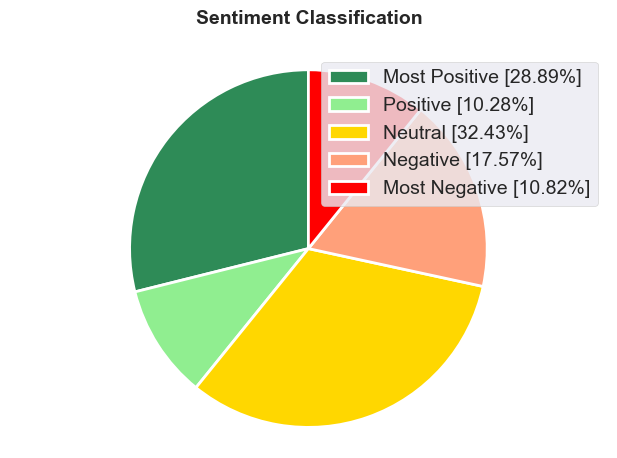

In [43]:
labels = ['Most Positive [' + str(round(per_most_pos_count, 2)) + '%]',
          'Positive [' + str(round(per_pos_count, 2)) + '%]',
          'Neutral [' + str(round(per_neu_count, 2)) + '%]',
          'Negative [' + str(round(per_neg_count, 2)) + '%]',
          'Most Negative [' + str(round(per_most_neg_count, 2)) + '%]']
sizes = [per_most_pos_count, per_pos_count, per_neu_count, per_neg_count, per_most_neg_count]
colors = ['seagreen', 'lightgreen', 'gold', 'lightsalmon', 'red']

# Create the pie chart
patches, texts = plt.pie(sizes, colors=colors, startangle=90)

for w in patches:
    w.set_linewidth(2)
    w.set_edgecolor('white')

plt.legend(patches, labels, loc="upper right")
plt.title('Sentiment Classification', fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [44]:
trend_df["Refined_Rating"] = ""

for i in range(len(trend_df)):
    if trend_df.loc[i, 'Class'] == 'pos' and trend_df.loc[i, 'Prob'] >= 0.80:
        trend_df.loc[i, 'Refined_Rating'] = 1.0
    elif trend_df.loc[i, 'Class'] == 'pos' and trend_df.loc[i, 'Prob'] < 0.80:
        trend_df.loc[i, 'Refined_Rating'] = 0.5
    elif trend_df.loc[i, 'Class'] == 'neu':
        trend_df.loc[i, 'Refined_Rating'] = 0
    elif trend_df.loc[i, 'Class'] == 'neg' and trend_df.loc[i, 'Prob'] >= 0.20:
        trend_df.loc[i, 'Refined_Rating'] = -0.5
    elif trend_df.loc[i, 'Class'] == 'neg' and trend_df.loc[i, 'Prob'] < 0.20:
        trend_df.loc[i, 'Refined_Rating'] = -1.0

trend_df.to_csv('Sentiment Trend.csv', encoding='utf-8')
trend_df.head()

,Date,Original_Tweet,Clean_Tweet,Class,Prob,Refined_Sentiment,Refined_Rating
0,2021-04-26,RT @VP: The U.S. is working closely with the I...,working closely indian government rapidly depl...,pos,0.719619,Positive,0.5
1,2021-04-26,"RT @BCGovNews: Join Adrian Dix, Minister of He...",join adrian dix minister health dr bonnie henr...,pos,0.876786,Most Positive,1.0
2,2021-04-26,Global stock markets made moderate gains on Mo...,global stock market made moderate gain monday ...,pos,0.857171,Most Positive,1.0
3,2021-04-26,Covid fatigue is apparently far more dangerous...,fatigue apparently far dangerous according,neg,0.166228,Most Negative,-1.0
4,2021-04-26,"RT @CraigKellyMP: Peer-reviewed study, by rese...",peer reviewed study researcher national univer...,neg,0.219964,Negative,-0.5


### **7.2.2 Date-wise Average Sentimet Trend**

In [45]:
avg_trend_df = trend_df.groupby('Date')['Refined_Rating'].mean().reset_index()

avg_trend_df.to_csv('Refined Sentiment Trend.csv', encoding='utf-8')
avg_trend_df.head()

,Date,Refined_Rating
0,2021-04-26,0.170406
1,2021-04-27,0.171233
2,2021-04-28,0.172991
3,2021-04-29,0.153390
4,2021-04-30,0.163601


### **7.2.3 Visualization of Average Sentimet Trend**

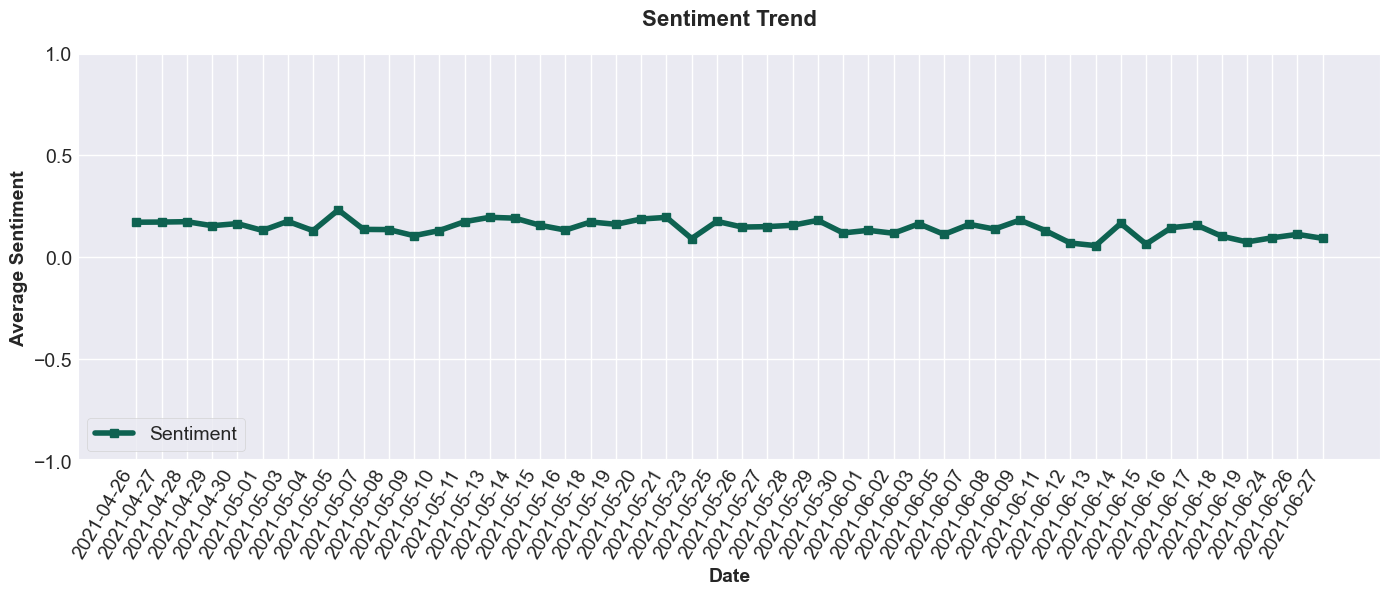

In [46]:
#Visualize the data
fig, ax = plt.subplots(figsize=(15, 6))
Date = avg_trend_df["Date"]
Sentiment = avg_trend_df["Refined_Rating"]
plt.plot(Date, Sentiment,'s-',color="#0e6251")

plt.title('Sentiment Trend', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Average Sentiment', fontsize=14, fontweight='bold')

plt.yticks(np.arange(-1.0, 1.2, 0.5))
plt.legend(['Sentiment'], loc='lower left')
fig.autofmt_xdate()
for tick in ax.get_xticklabels():
    tick.set_rotation(60)
plt.show()

## **7.3 Average Binary Sentiment Trend Shift**

### **7.3.1 Binary Sentiment Ratings Assignment**

In [47]:
binary_df = trend_df[trend_df['Class'].isin(['pos', 'neg'])].copy()

binary_trend_df = pd.DataFrame()
binary_trend_df["Date"] = binary_df['Date'].unique()

positive_trend = binary_df[binary_df['Class'] == 'pos'].groupby('Date')['Refined_Rating'].mean()
negative_trend = binary_df[binary_df['Class'] == 'neg'].groupby('Date')['Refined_Rating'].mean()

positive_trend_df = positive_trend.reset_index()
positive_trend_df.columns = ['Date', 'Positive_Rating']

negative_trend_df = negative_trend.reset_index()
negative_trend_df.columns = ['Date', 'Negative_Rating']

binary_trend_df["Positive_Rating"] = positive_trend_df['Positive_Rating']
binary_trend_df["Negative_Rating"] = negative_trend_df['Negative_Rating']
binary_trend_df.reset_index(drop=True, inplace=True)
binary_trend_df = binary_trend_df.set_index(['Date'])
binary_trend_df.head()

,Positive_Rating,Negative_Rating
Date,,
2021-04-26,0.869083,-0.658432
2021-04-27,0.862637,-0.602941
2021-04-28,0.873199,-0.673404
2021-04-29,0.863095,-0.686486
2021-04-30,0.852796,-0.660539


### **7.3.2 Visualization of Average Binary Sentimet Trend**

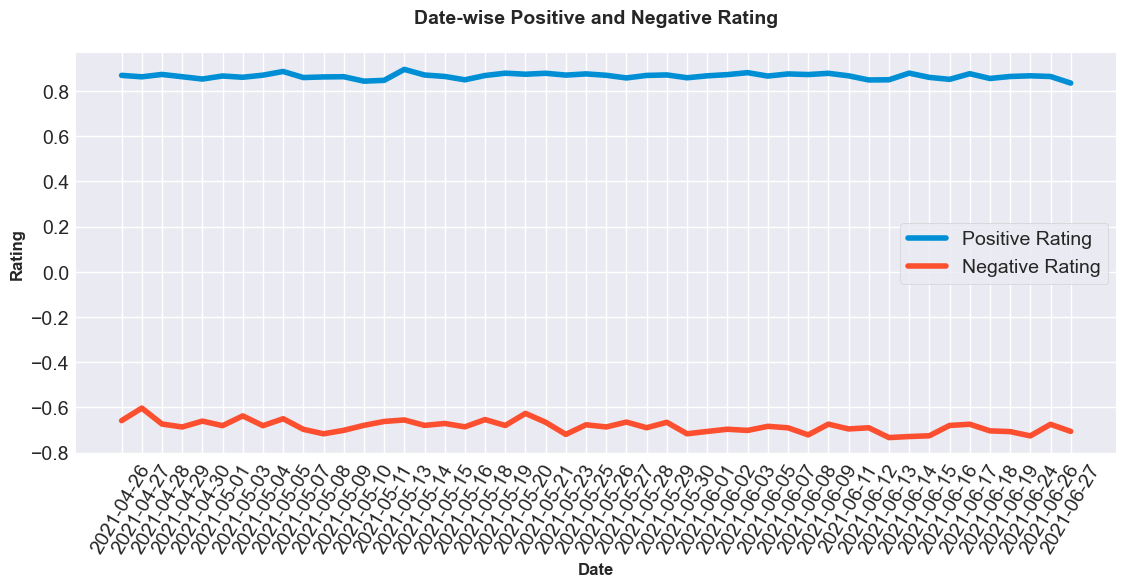

In [48]:
# Plotting date-wise Positive_Rating and Negative_Rating
plt.figure(figsize=(12, 5))  # Set the figure size

sns.lineplot(data=binary_trend_df, x=binary_trend_df.index, y='Positive_Rating', label='Positive Rating')
sns.lineplot(data=binary_trend_df, x=binary_trend_df.index, y='Negative_Rating', label='Negative Rating')

plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Rating', fontsize=12, fontweight='bold')
plt.title('Date-wise Positive and Negative Rating', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="center right")
plt.xticks(rotation=60)
plt.show()

In [49]:
# 3D Visualization of Average Binary Sentimet Trend
dates = binary_trend_df.index

# Make Plotly figure
fig1 = go.Scatter3d(x=binary_trend_df["Positive_Rating"],
                    y=binary_trend_df['Negative_Rating'],
                    z=dates,
                    marker=dict(opacity=0.9,
                                reversescale=True,
                                colorscale='Blues',
                                size=5),
                    line=dict (width=0.02),
                    mode='markers')

# Make Plotly Layout
mylayout = go.Layout(scene=dict(xaxis=dict(title="Positive Sentiment", range=[0.0, 1.0], tickmode='linear', dtick=0.2),
                                yaxis=dict(title="Negative Sentiment", range=[-1.0, 0.0], tickmode='linear', dtick=0.2),
                                zaxis=dict(title="Date", tickmode='array')),
                     title='3D Sentiment Plot',
                     margin=dict(l=0, r=0, b=0, t=0),
                     scene_aspectmode='manual',
                     scene_aspectratio=dict(x=1, y=1, z=1))

# Plot and save html
plotly.offline.plot({"data": [fig1],
                     "layout": mylayout},
                     auto_open=True,
                     filename=("3D Datewise Sentiment Plot.html"))

'3D Datewise Sentiment Plot.html'

# **8. Predictive Modeling - Data Preparation**

## **8.1 Prepare Final Data**

In [50]:
cols = ['Sentiment', 'Text']
final_data_df = pd.DataFrame(columns=cols, index=range(len(trend_df.index)))
final_data_df["Sentiment"] = ""

for i in range(0,len(trend_df.index)):
    if trend_df['Refined_Sentiment'].iloc[i] == 'Most Negative':
        final_data_df['Sentiment'].iloc[i] = 0
    elif trend_df['Refined_Sentiment'].iloc[i] == 'Negative':
        final_data_df['Sentiment'].iloc[i] = 1
    elif trend_df['Refined_Sentiment'].iloc[i] == 'Neutral':
        final_data_df['Sentiment'].iloc[i] = 2
    elif trend_df['Refined_Sentiment'].iloc[i] == 'Positive':
        final_data_df['Sentiment'].iloc[i] = 3
    else:
        final_data_df['Sentiment'].iloc[i] = 4

final_data_df["Text"] = trend_df['Clean_Tweet']
final_data_df.to_csv("Final Tweet Data.csv", index=False)
final_data_df.head()

,Sentiment,Text
0,3,working closely indian government rapidly depl...
1,4,join adrian dix minister health dr bonnie henr...
2,4,global stock market made moderate gain monday ...
3,0,fatigue apparently far dangerous according
4,1,peer reviewed study researcher national univer...


## **8.2 Vectorization**

In [51]:
def ingest():
    data = pd.read_csv('Final Tweet Data.csv')
    data = data[data.Sentiment.isnull() == False]
    data['Sentiment'] = data['Sentiment'].map(int)
    data = data[data['Text'].isnull() == False]
    data.reset_index(inplace=True)
    data.drop('index',axis=1,inplace=True)
    print ('dataset loaded with shape', data.shape)
    return data

In [52]:
data = ingest()
data.head()

dataset loaded with shape (146373, 2)


,Sentiment,Text
0,3,working closely indian government rapidly depl...
1,4,join adrian dix minister health dr bonnie henr...
2,4,global stock market made moderate gain monday ...
3,0,fatigue apparently far dangerous according
4,1,peer reviewed study researcher national univer...


In [53]:
tokenizer = TweetTokenizer()
vectorizer = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer.tokenize)
full_text = list(data['Text'].values)
vectorizer.fit(full_text)
vectorize_data = vectorizer.transform(data['Text'])
y = data['Sentiment']

C:\Users\Arunava\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [54]:
X = data['Text']
Y = to_categorical(data['Sentiment'].values)
print(Y)

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


## **8.3 Train-Test Split**

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

print("Shape of X_train data =", X_train.shape)
print("Shape of X_val data =", X_test.shape)
print("Shape of y_train data =", y_train.shape)
print("Shape of y_val data =", y_test.shape)

Shape of X_train data = (117098,)
Shape of X_val data = (29275,)
Shape of y_train data = (117098, 5)
Shape of y_val data = (29275, 5)


## **8.4 Final Data Preparation**

### **8.4.1 Total number of words/features**

In [56]:
all_words=' '.join(X_train)
all_words=word_tokenize(all_words)
dist=FreqDist(all_words)

num_unique_word=len(dist)
print ("Total number of unique words in training set is", num_unique_word)

Total number of unique words in training set is 50078


### **8.4.2 Number of words for each phrase/text**

In [57]:
tweet_len=[]
for text in X_train:
    word=word_tokenize(text)
    l=len(word)
    tweet_len.append(l)

max_tweet_len=np.max(tweet_len)
print ("Maximum length of a tweet in training set is", max_tweet_len)

Maximum length of a tweet in training set is 31


In [58]:
max_features = num_unique_word
max_words = max_tweet_len

### **8.4.3 Tokenizing the words**

In [59]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### **8.4.4 Sequence Padding**

In [60]:
X_train = pad_sequences(X_train, maxlen=max_words)
X_test = pad_sequences(X_test, maxlen=max_words)

# **9. Predictive Modeling - Hybrid Convolutional LSTM**

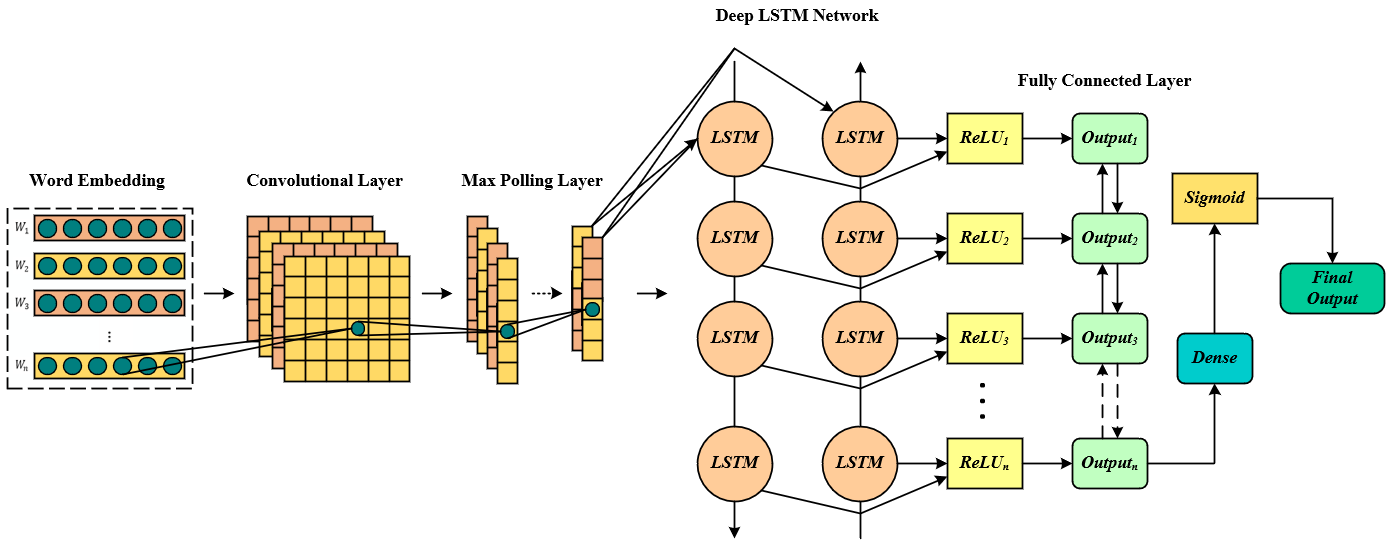

## **9.1 CNN + Sequential LSTM**

### **9.1.1 Model Implementation**

In [61]:
model1 = Sequential()
model1.add(Embedding(max_features, 100, input_length=max_words))
model1.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.25))

model1.add(LSTM(128, return_sequences=True))
model1.add(Dropout(0.2))

model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.1))

model1.add(Dense(32, activation='relu'))
model1.add(Dense(5, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 31, 100)           5007800   
                                                                 
 conv1d (Conv1D)             (None, 31, 128)           38528     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 128)           0         
                                                                 
 lstm (LSTM)                 (None, 15, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 15, 128)           0         
                                                        

### **9.1.2 CNN + Seq-LSTM Model Training**

In [62]:
history = model1.fit(X_train, y_train, epochs=6, validation_data=(X_test, y_test), batch_size=32, verbose=2)

Epoch 1/6
3660/3660 - 38s - loss: 0.1993 - accuracy: 0.7793 - val_loss: 0.1409 - val_accuracy: 0.8522 - 38s/epoch - 10ms/step
Epoch 2/6
3660/3660 - 32s - loss: 0.1061 - accuracy: 0.8914 - val_loss: 0.1321 - val_accuracy: 0.8649 - 32s/epoch - 9ms/step
Epoch 3/6
3660/3660 - 32s - loss: 0.0722 - accuracy: 0.9307 - val_loss: 0.1372 - val_accuracy: 0.8692 - 32s/epoch - 9ms/step
Epoch 4/6
3660/3660 - 32s - loss: 0.0510 - accuracy: 0.9518 - val_loss: 0.1477 - val_accuracy: 0.8712 - 32s/epoch - 9ms/step
Epoch 5/6
3660/3660 - 32s - loss: 0.0377 - accuracy: 0.9653 - val_loss: 0.1750 - val_accuracy: 0.8699 - 32s/epoch - 9ms/step
Epoch 6/6
3660/3660 - 32s - loss: 0.0301 - accuracy: 0.9730 - val_loss: 0.1949 - val_accuracy: 0.8658 - 32s/epoch - 9ms/step


### **9.1.3 Visualization of Accuracy & Loss during Training & Validation of CNN + Seq-LSTM Model**

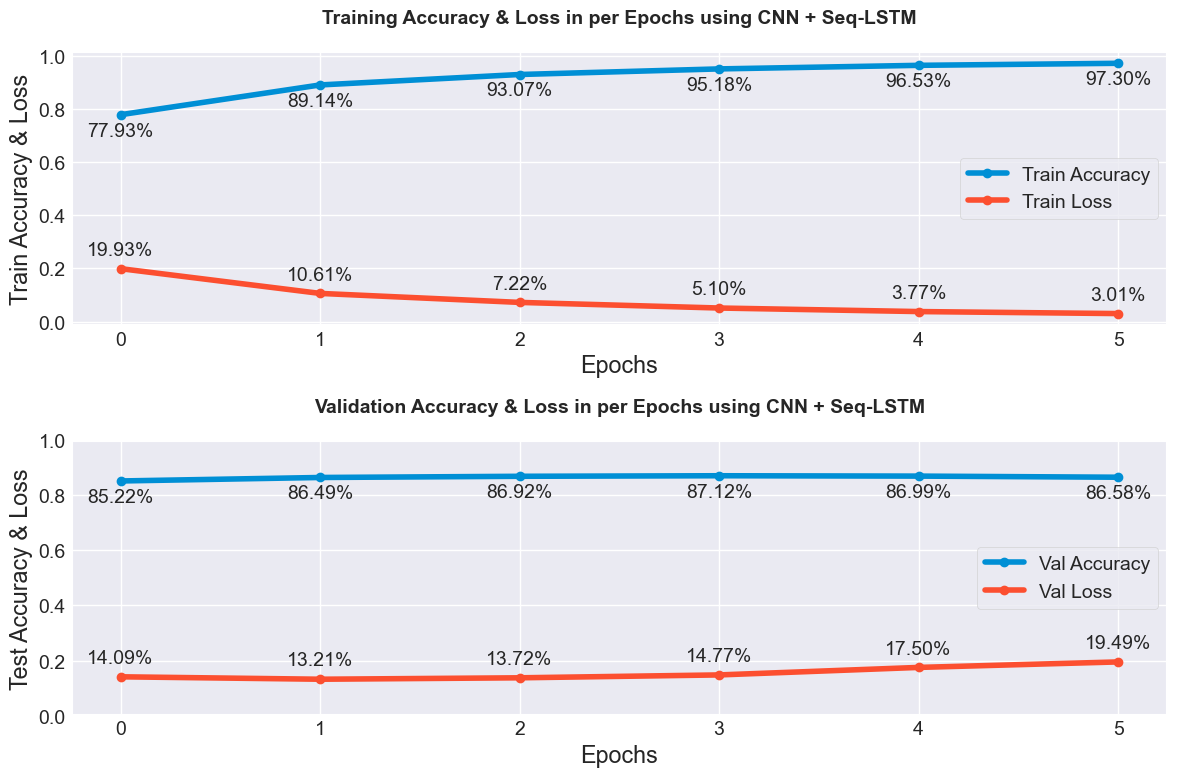

In [63]:
# Visualize Accuracy & Loss during Training & Validation of CNN + Seq-LSTM Model
fig,ax =  plt.subplots(2)
fig.set_figheight(8)
fig.set_figwidth(12)
xs = np.arange(0,6,1)
ys = [None]*16
ys1 = history.history['accuracy']
ys2 = history.history['loss']
ax[0].plot(history.history['accuracy'],'o-')
ax[0].plot(history.history['loss'],'o-')
ax[0].set_title('Training Accuracy & Loss in per Epochs using CNN + Seq-LSTM', fontsize=14, fontweight='bold', pad=20)
ax[0].set(xlabel='Epochs')
ax[0].set(ylabel='Train Accuracy & Loss')
ax[0].set_xticks(np.arange(0,6,1))
ax[0].set_yticks(np.arange(0.0,1.2,0.2))
ax[0].legend(["Train Accuracy", "Train Loss"], loc ="center right")

for i,j in zip(range(0,6,1), range(0,6)):
    ys[j] = ys1[i]

for x,y in zip(xs,ys):
    label = "{:.2f}%".format(y*100)
    ax[0].annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center')

for i,j in zip(range(0,6,1), range(0,6)):
    ys[j] = ys2[i]

for x,y in zip(xs,ys):
    label = "{:.2f}%".format(y*100)
    ax[0].annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')


xs = np.arange(0,6,1)
ys3 = history.history['val_accuracy']
ys4 = history.history['val_loss']
ax[1].plot(history.history['val_accuracy'],'o-')
ax[1].plot(history.history['val_loss'],'o-')
ax[1].set_title('Validation Accuracy & Loss in per Epochs using CNN + Seq-LSTM', fontsize=14, fontweight='bold', pad=20)
ax[1].set(xlabel='Epochs')
ax[1].set(ylabel='Test Accuracy & Loss')
ax[1].set_xticks(np.arange(0,6,1))
ax[1].set_yticks(np.arange(0.0,1.2,0.2))
ax[1].legend(["Val Accuracy", "Val Loss"], loc ="center right")

for i,j in zip(range(0,6,1), range(0,6)):
    ys[j] = ys3[i]

for x,y in zip(xs,ys):
    label = "{:.2f}%".format(y*100)
    ax[1].annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center')

for i,j in zip(range(0,6,1), range(0,6)):
    ys[j] = ys4[i]

for x,y in zip(xs,ys):
    label = "{:.2f}%".format(y*100)
    ax[1].annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')

plt.tight_layout()

#### **9.1.3.1 Final Validation Accuracy of CNN + Seq-LSTM Model**

In [64]:
score = model1.evaluate(X_test, y_test, batch_size=32, verbose=2)
print (score[1])

915/915 - 2s - loss: 0.1949 - accuracy: 0.8658 - 2s/epoch - 3ms/step
0.8657899498939514


### **9.1.4 Classification Report & Confusion Matrix**

#### **9.1.4.1 Classification Report**

In [65]:
# Get predictions on the test data
y_pred = model1.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to categorical labels
y_true_cat = np.argmax(y_test, axis=1)

class_labels = ['Most Negative', 'Negative', 'Neutral', 'Positive', 'Most Positive']

# Generate the classification report
report = classification_report(y_true_cat, y_pred, target_names=class_labels)

# Print the classification report
print()
print("\t\t: Classification Report - CNN + Seq-LSTM :\t\t")
print("\t\t==========================================\t\t")
print()
print(report)

915/915 [==============================] - 2s 2ms/step

		: Classification Report - CNN + Seq-LSTM :		

               precision    recall  f1-score   support

Most Negative       0.84      0.84      0.84      3145
     Negative       0.83      0.76      0.80      5111
      Neutral       0.98      0.96      0.97      9462
     Positive       0.55      0.65      0.60      2944
Most Positive       0.89      0.91      0.90      8613

     accuracy                           0.87     29275
    macro avg       0.82      0.82      0.82     29275
 weighted avg       0.87      0.87      0.87     29275



#### **9.1.4.2 Confusion Matrix**

Text(0.5, 1.0, 'Confusion Matrix - CNN + Seq-LSTM')

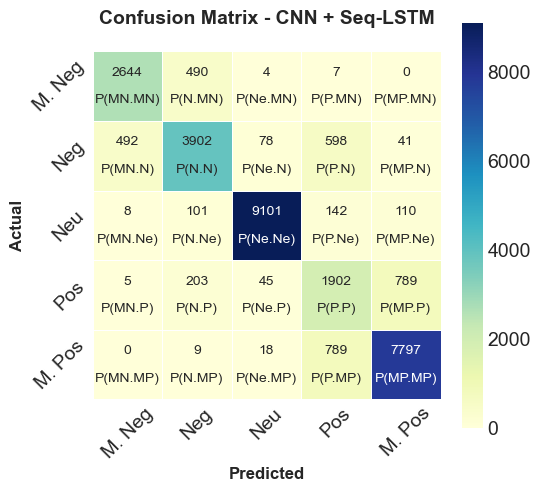

In [66]:
# Calculate confusion matrix
conf_mat = confusion_matrix(y_true_cat, y_pred)
data = np.array([['P(MN.MN)', 'P(N.MN)', 'P(Ne.MN)', 'P(P.MN)', 'P(MP.MN)'],
                 ['P(MN.N)', 'P(N.N)', 'P(Ne.N)', 'P(P.N)', 'P(MP.N)'],
                 ['P(MN.Ne)', 'P(N.Ne)', 'P(Ne.Ne)', 'P(P.Ne)', 'P(MP.Ne)'],
                 ['P(MN.P)', 'P(N.P)', 'P(Ne.P)', 'P(P.P)', 'P(MP.P)'],
                 ['P(MN.MP)', 'P(N.MP)', 'P(Ne.MP)', 'P(P.MP)', 'P(MP.MP)'],
                ])

# combining text with values
formatted_text = (np.asarray(["{0:d}\n\n{1}".format(
    conf_mat, data) for conf_mat, data in zip(conf_mat.flatten(), data.flatten())])).reshape(5, 5)

fig, ax = plt.subplots(figsize=(5, 5))  # Set the figure size

axes = sns.heatmap(conf_mat, square=True, annot=formatted_text, annot_kws={"size":10}, fmt='',
                  cbar=True, cmap=plt.cm.YlGnBu, linewidths=0.5, linecolor='white')
class_labels = ['M. Neg', 'Neg', 'Neu', 'Pos', 'M. Pos']

axes.set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes.set_ylabel('Actual', fontsize=12, fontweight='bold')

xtick_marks = np.arange(len(class_labels)) + 0.5
ytick_marks = np.arange(len(class_labels)) + 0.5

axes.set_xticks(xtick_marks)
axes.set_xticklabels(class_labels, rotation=45)

axes.set_yticks(ytick_marks)
axes.set_yticklabels(class_labels, rotation=45)

axes.set_title('Confusion Matrix - CNN + Seq-LSTM', fontsize=14, fontweight='bold', pad=20)

# **9.2 CNN + Bidirectional LSTM**

### **9.2.1 Model Implementation**

In [67]:
model2 = Sequential()
model2.add(Embedding(max_features, 100, input_length=max_words))
model2.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.25))

model2.add(Bidirectional(LSTM(128, return_sequences=True)))
model2.add(Dropout(0.2))

model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.1))

model2.add(Dense(32, activation='relu'))
model2.add(Dense(5, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 31, 100)           5007800   
                                                                 
 conv1d_1 (Conv1D)           (None, 31, 128)           38528     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 15, 128)          0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 15, 128)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 15, 256)          263168    
 l)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 15, 256)          

### **9.2.2 CNN + Bi-LSTM Model Training**

In [68]:
history = model2.fit(X_train, y_train, epochs=6, validation_data=(X_test, y_test), batch_size=32, verbose=2)

Epoch 1/6
3660/3660 - 44s - loss: 0.1969 - accuracy: 0.7827 - val_loss: 0.1411 - val_accuracy: 0.8521 - 44s/epoch - 12ms/step
Epoch 2/6
3660/3660 - 41s - loss: 0.1036 - accuracy: 0.8933 - val_loss: 0.1336 - val_accuracy: 0.8647 - 41s/epoch - 11ms/step
Epoch 3/6
3660/3660 - 42s - loss: 0.0688 - accuracy: 0.9329 - val_loss: 0.1346 - val_accuracy: 0.8702 - 42s/epoch - 11ms/step
Epoch 4/6
3660/3660 - 47s - loss: 0.0474 - accuracy: 0.9554 - val_loss: 0.1561 - val_accuracy: 0.8702 - 47s/epoch - 13ms/step
Epoch 5/6
3660/3660 - 41s - loss: 0.0359 - accuracy: 0.9672 - val_loss: 0.1609 - val_accuracy: 0.8635 - 41s/epoch - 11ms/step
Epoch 6/6
3660/3660 - 41s - loss: 0.0277 - accuracy: 0.9748 - val_loss: 0.1808 - val_accuracy: 0.8722 - 41s/epoch - 11ms/step


### **9.2.3 Visualization of Accuracy & Loss during Training & Validation of CNN + Bi-LSTM Model**

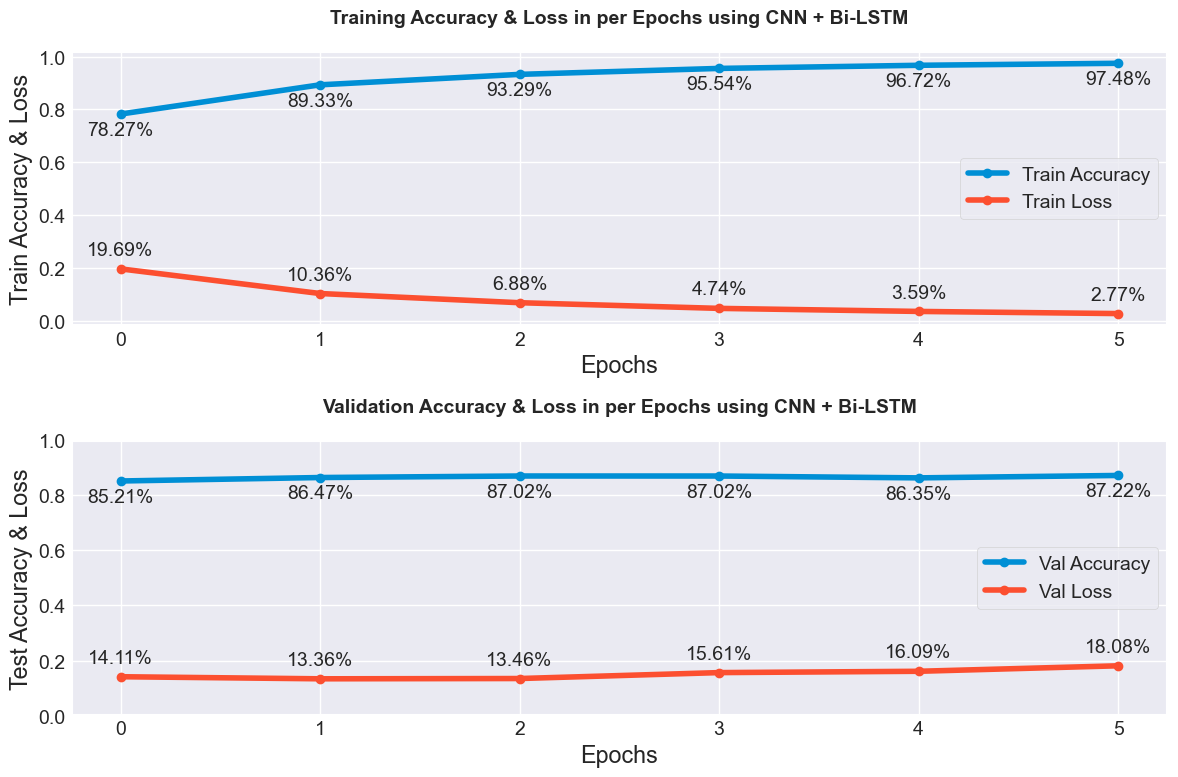

In [69]:
# Visualize Accuracy & Loss during Training & Validation of CNN + Bi-LSTM Model
fig,ax =  plt.subplots(2)
fig.set_figheight(8)
fig.set_figwidth(12)
xs = np.arange(0,6,1)
ys = [None]*16
ys1 = history.history['accuracy']
ys2 = history.history['loss']
ax[0].plot(history.history['accuracy'],'o-')
ax[0].plot(history.history['loss'],'o-')
ax[0].set_title('Training Accuracy & Loss in per Epochs using CNN + Bi-LSTM', fontsize=14, fontweight='bold', pad=20)
ax[0].set(xlabel='Epochs')
ax[0].set(ylabel='Train Accuracy & Loss')
ax[0].set_xticks(np.arange(0,6,1))
ax[0].set_yticks(np.arange(0.0,1.2,0.2))
ax[0].legend(["Train Accuracy", "Train Loss"], loc ="center right")

for i,j in zip(range(0,6,1), range(0,6)):
    ys[j] = ys1[i]

for x,y in zip(xs,ys):
    label = "{:.2f}%".format(y*100)
    ax[0].annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center')

for i,j in zip(range(0,6,1), range(0,6)):
    ys[j] = ys2[i]

for x,y in zip(xs,ys):
    label = "{:.2f}%".format(y*100)
    ax[0].annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')


xs = np.arange(0,6,1)
ys3 = history.history['val_accuracy']
ys4 = history.history['val_loss']
ax[1].plot(history.history['val_accuracy'],'o-')
ax[1].plot(history.history['val_loss'],'o-')
ax[1].set_title('Validation Accuracy & Loss in per Epochs using CNN + Bi-LSTM', fontsize=14, fontweight='bold', pad=20)
ax[1].set(xlabel='Epochs')
ax[1].set(ylabel='Test Accuracy & Loss')
ax[1].set_xticks(np.arange(0,6,1))
ax[1].set_yticks(np.arange(0.0,1.2,0.2))
ax[1].legend(["Val Accuracy", "Val Loss"], loc ="center right")

for i,j in zip(range(0,6,1), range(0,6)):
    ys[j] = ys3[i]

for x,y in zip(xs,ys):
    label = "{:.2f}%".format(y*100)
    ax[1].annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center')

for i,j in zip(range(0,6,1), range(0,6)):
    ys[j] = ys4[i]

for x,y in zip(xs,ys):
    label = "{:.2f}%".format(y*100)
    ax[1].annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')

plt.tight_layout()

#### **9.2.3.1 Final Validation Accuracy of CNN + Bi-LSTM Model**

In [70]:
score = model2.evaluate(X_test, y_test, batch_size=32, verbose=2)
print (score[1])

915/915 - 3s - loss: 0.1808 - accuracy: 0.8722 - 3s/epoch - 3ms/step
0.8722118139266968


### **9.2.4 Classification Report & Confusion Matrix**

#### **9.2.4.1 Classification Report**

In [71]:
# Get predictions on the test data
y_pred = model2.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to categorical labels
y_true_cat = np.argmax(y_test, axis=1)

class_labels = ['Most Negative', 'Negative', 'Neutral', 'Positive', 'Most Positive']

# Generate the classification report
report = classification_report(y_true_cat, y_pred, target_names=class_labels)

# Print the classification report
print()
print("\t\t: Classification Report - CNN + Bi-LSTM :\t\t")
print("\t\t=========================================\t\t")
print()
print(report)

915/915 [==============================] - 4s 3ms/step

		: Classification Report - CNN + Bi-LSTM :		

               precision    recall  f1-score   support

Most Negative       0.84      0.85      0.84      3145
     Negative       0.82      0.80      0.81      5111
      Neutral       0.99      0.96      0.97      9462
     Positive       0.60      0.56      0.58      2944
Most Positive       0.88      0.93      0.91      8613

     accuracy                           0.87     29275
    macro avg       0.82      0.82      0.82     29275
 weighted avg       0.87      0.87      0.87     29275



#### **9.2.4.2 Confusion Matrix**

Text(0.5, 1.0, 'Confusion Matrix - CNN + Bi-LSTM')

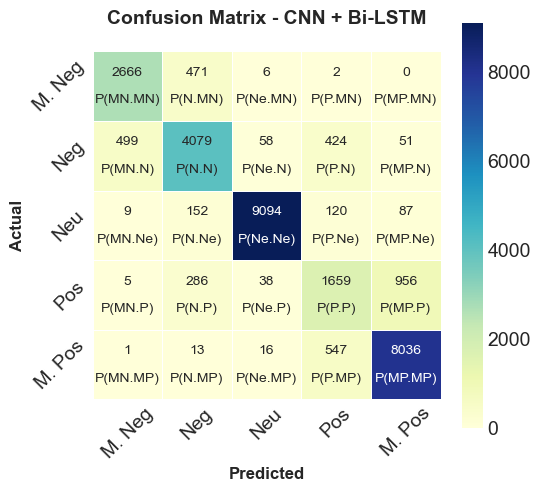

In [72]:
# Calculate confusion matrix
conf_mat = confusion_matrix(y_true_cat, y_pred)
data = np.array([['P(MN.MN)', 'P(N.MN)', 'P(Ne.MN)', 'P(P.MN)', 'P(MP.MN)'],
                 ['P(MN.N)', 'P(N.N)', 'P(Ne.N)', 'P(P.N)', 'P(MP.N)'],
                 ['P(MN.Ne)', 'P(N.Ne)', 'P(Ne.Ne)', 'P(P.Ne)', 'P(MP.Ne)'],
                 ['P(MN.P)', 'P(N.P)', 'P(Ne.P)', 'P(P.P)', 'P(MP.P)'],
                 ['P(MN.MP)', 'P(N.MP)', 'P(Ne.MP)', 'P(P.MP)', 'P(MP.MP)'],
                ])

# combining text with values
formatted_text = (np.asarray(["{0:d}\n\n{1}".format(
    conf_mat, data) for conf_mat, data in zip(conf_mat.flatten(), data.flatten())])).reshape(5, 5)

fig, ax = plt.subplots(figsize=(5, 5))  # Set the figure size

axes = sns.heatmap(conf_mat, square=True, annot=formatted_text, annot_kws={"size":10}, fmt='',
                  cbar=True, cmap=plt.cm.YlGnBu, linewidths=0.5, linecolor='white')
class_labels = ['M. Neg', 'Neg', 'Neu', 'Pos', 'M. Pos']

axes.set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes.set_ylabel('Actual', fontsize=12, fontweight='bold')

xtick_marks = np.arange(len(class_labels)) + 0.5
ytick_marks = np.arange(len(class_labels)) + 0.5

axes.set_xticks(xtick_marks)
axes.set_xticklabels(class_labels, rotation=45)

axes.set_yticks(ytick_marks)
axes.set_yticklabels(class_labels, rotation=45)

axes.set_title('Confusion Matrix - CNN + Bi-LSTM', fontsize=14, fontweight='bold', pad=20)